# Statistical Outlier Detection

This anomaly detection method involves computing basic statistics about the data and determining outliers based on z-score values. 

How to calculate a z-score for a given data point x:\
z-score = (mean - x)/standard_deviation

We consider an outlier to be any data point outside of a 3 standard deviation range from the mean.

In [3]:
# import necessary dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

In [4]:
data = pd.read_csv('intc_data.csv')

In [5]:
# Calculate standard deviation
std_dev = data['Volume'].std()

# Identify outliers
outliers = data[(data['Volume'] > (data['Volume'].mean() + 3 * std_dev)) |
                (data['Volume'] < (data['Volume'].mean() - 3 * std_dev))]

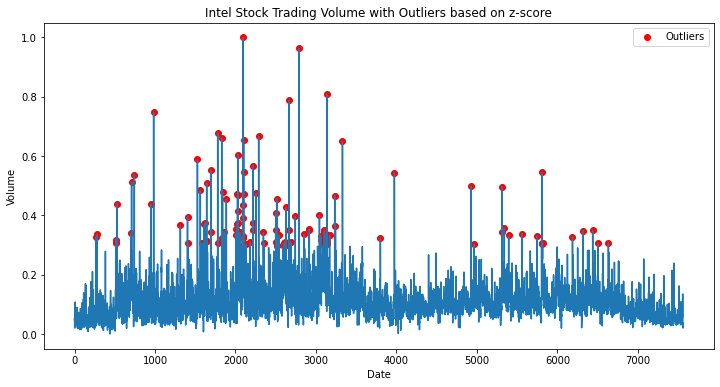

In [6]:
# Plot outliers
plt.figure(figsize=(12, 6))
plt.plot(data['Volume'])
plt.scatter(outliers.index, outliers['Volume'], color='red', label='Outliers')
plt.title('Intel Stock Trading Volume with Outliers based on z-score')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

As we can see, this method is particularly effective at identifying peaks in the data because they tend to deviate signficantly from the mean. Since the data is right-skewed, none of the troughs are identified because the mean trading volume itself is relatively low.  